# Classifying eyes as female or male using Convolutional Neural Network

<p><img src = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRQtQnWtMBaRN0OznlOnl98spYju8ijAMTUVA&usqp=CAU" alt align="center"></p>

## Dataset information:

- The data was collected to train a model to distinguish between images containing Female eyes and images of Male eyes, so the whole problem is binary classification.


The data is divided into 2 folders:
- The folder `` femaleeyes`` contains 5202 images and the folder `` maleeyes`` contains 6323 images for training and testing the model.

The dataset can be found on the `` Kaggle`` platform at the link below:

- https://www.kaggle.com/pavelbiz/eyes-rtte

This notebook has been adapted from
- https://www.kaggle.com/lucasar/detection-of-male-female-eyes-convnet-92-acc

which evaluated 4 models. The single model used in current notebook is the best-performing of the 4.

# 1. Imports from libraries

In [80]:
import pandas as pd
import numpy as np
import datetime as dt
import os
import os.path
from pathlib import Path
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, recall_score, precision_score, f1_score, roc_auc_score, roc_curve

#import pydot      #Python interface to graphviz's dot language (scalable vector graphics)
#import graphviz

# 2. Organizing Training and Testing Dataframes

https://docs.python.org/3/library/pathlib.html

If you’ve never used this module before or just aren’t sure which class is right for your task, Path is most likely what you need. It instantiates a concrete path for the platform the code is running on.

In [81]:
# Selecting Dataset Folder Paths
f_dir_ = Path('../input/eyes-rtte/femaleeyes')
m_dir_ = Path('../input/eyes-rtte/maleeyes')
f_dir_

PosixPath('../input/eyes-rtte/femaleeyes')

https://docs.python.org/3/library/glob.html

The glob module finds all the pathnames matching a specified pattern according to the rules used by the Unix shell, although results are returned in arbitrary order.

In [82]:
femaleeyes_filepaths = list(f_dir_.glob(r'**/*.jpg'))
maleeyes_filepaths = list(m_dir_.glob(r'**/*.jpg'))
femaleeyes_filepaths[:2]

[PosixPath('../input/eyes-rtte/femaleeyes/6400.jpg'),
 PosixPath('../input/eyes-rtte/femaleeyes/823.jpg')]

lambda is inline function creation, with format 'lambda input:output'

The map() function (which is a built-in function in Python) is used to apply a function to each item in an iterable (like a Python list or dictionary). It returns a new iterable (a map object) that you can use in other parts of your code.
https://www.freecodecamp.org/news/python-map-explained-with-examples/

In [83]:
# Mapping the labels
# (just extracts folder name from each filepath, which is the same for each label category)
fm_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], femaleeyes_filepaths))
ml_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], maleeyes_filepaths))
fm_labels[:2]

['femaleeyes', 'femaleeyes']

In [84]:
# Make a DataFrame of paths and labels for female and male images, in stages:

# Make Series for paths & labels of female eyes
fm_filepaths = pd.Series(femaleeyes_filepaths, name = 'File').astype(str)
fm_labels = pd.Series(fm_labels, name='Label')

# Make Series for paths & labels of male eyes
ml_filepaths = pd.Series(maleeyes_filepaths, name = 'File').astype(str)
ml_labels = pd.Series(ml_labels, name='Label')

# Create DataFrame
femaleeyes_df = pd.concat([fm_filepaths, fm_labels], axis=1)
maleeyes_df = pd.concat([ml_filepaths, ml_labels], axis=1)
df = pd.concat([femaleeyes_df, maleeyes_df])

# <<CB: reshuffle the male and female rows in dataframe by resampling all>>
# <<probably only done for displaying some files early, since test_train_split should also randomize>>
df = df.sample(frac = 1, random_state = 56).reset_index(drop = True)
df.head()

,File,Label
0,../input/eyes-rtte/femaleeyes/5726.jpg,femaleeyes
1,../input/eyes-rtte/femaleeyes/6719.jpg,femaleeyes
2,../input/eyes-rtte/femaleeyes/1733.jpg,femaleeyes
3,../input/eyes-rtte/femaleeyes/3614.jpg,femaleeyes
4,../input/eyes-rtte/femaleeyes/1808.jpg,femaleeyes


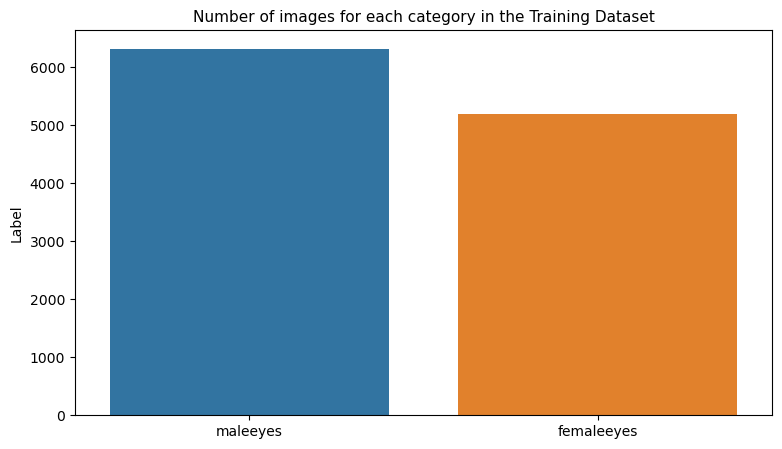

In [138]:
vc = df['Label'].value_counts()
plt.style.use("default")
plt.figure(figsize = (9, 5))
sns.barplot(x = vc.index, y = vc)
plt.title("Number of images for each category in the Training Dataset", fontsize = 11)
plt.show()

# 3. Observing the images

In [86]:
plt.style.use("dark_background")
plt.style.use("default")

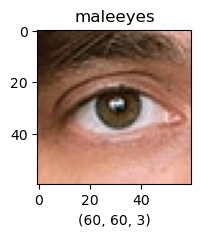

In [87]:
figure = plt.figure(figsize=(2,2))
x = plt.imread(df["File"][34])
plt.imshow(x)
plt.xlabel(x.shape)
plt.title(df["Label"][34]);

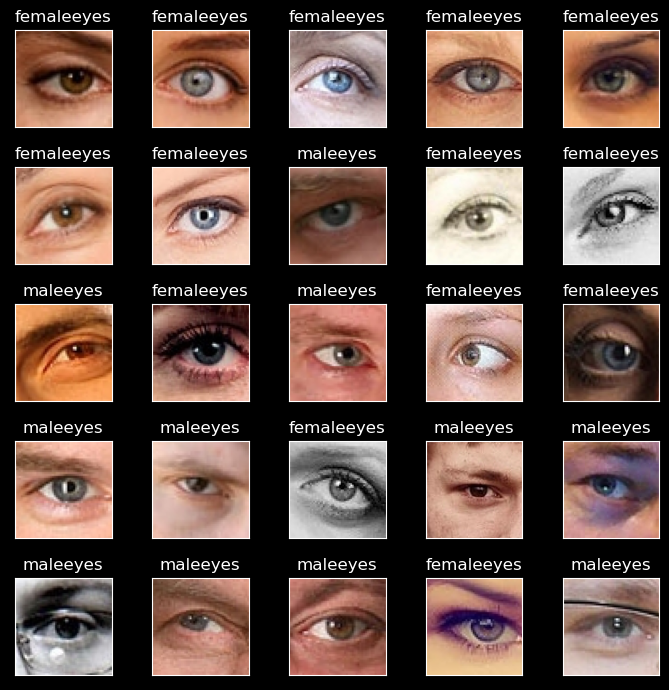

In [154]:
plt.style.use("dark_background")
fig, axes = plt.subplots(nrows = 5,
                        ncols = 5,
                        figsize = (7, 7),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df["File"][i]))
    ax.set_title(df["Label"][i])
plt.tight_layout()
plt.show()

# 3. Dividing into training and testing sets
Now we need to convert our data into training and testing sets. We will use 75% of the images as our training data and test our model on the remaining 25% with Scikit-learn's train_test_split function.

In [89]:
trainset_df, testset_df = train_test_split(df, train_size = 0.75, random_state = 4)

display(trainset_df.head())

testset_df.head()

,File,Label
5614,../input/eyes-rtte/maleeyes/3410.jpg,maleeyes
862,../input/eyes-rtte/femaleeyes/3709.jpg,femaleeyes
9030,../input/eyes-rtte/femaleeyes/2732.jpg,femaleeyes
7482,../input/eyes-rtte/maleeyes/2801.jpg,maleeyes
5000,../input/eyes-rtte/maleeyes/2899.jpg,maleeyes


,File,Label
3814,../input/eyes-rtte/femaleeyes/2278.jpg,femaleeyes
5238,../input/eyes-rtte/femaleeyes/4920.jpg,femaleeyes
2768,../input/eyes-rtte/femaleeyes/7195.jpg,femaleeyes
2398,../input/eyes-rtte/maleeyes/1881.jpg,maleeyes
9093,../input/eyes-rtte/maleeyes/6197.jpg,maleeyes


https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

Encode target labels with value between 0 and n_classes-1.

In [90]:
# converting the Label to a numeric format for testing later...
LE = LabelEncoder()

y_test = LE.fit_transform(testset_df["Label"])

In [91]:
# Add y_test as new column in testset_df (_df2 actually).
# Since join is on index, need to reset first
testset_df2 = pd.concat([testset_df.reset_index(),pd.Series(data=y_test,name='Label_numeric')],axis=1)

In [92]:
testset_df2.head(10)

,index,File,Label,Label_numeric
0,3814,../input/eyes-rtte/femaleeyes/2278.jpg,femaleeyes,0
1,5238,../input/eyes-rtte/femaleeyes/4920.jpg,femaleeyes,0
2,2768,../input/eyes-rtte/femaleeyes/7195.jpg,femaleeyes,0
3,2398,../input/eyes-rtte/maleeyes/1881.jpg,maleeyes,1
4,9093,../input/eyes-rtte/maleeyes/6197.jpg,maleeyes,1
5,3179,../input/eyes-rtte/femaleeyes/6546.jpg,femaleeyes,0
6,10846,../input/eyes-rtte/maleeyes/4050.jpg,maleeyes,1
7,9405,../input/eyes-rtte/maleeyes/4912.jpg,maleeyes,1
8,1017,../input/eyes-rtte/maleeyes/5968.jpg,maleeyes,1
9,6860,../input/eyes-rtte/femaleeyes/871.jpg,femaleeyes,0


In [93]:
testset_df2.shape

(2882, 4)

In [94]:
# Viewing data in training dataset
print('Training Dataset:')

print(f'Number of images: {trainset_df.shape[0]}')

print(f'Number of images with male eyes: {trainset_df["Label"].value_counts()[0]}')
print(f'Number of images with female eyes: {trainset_df["Label"].value_counts()[1]}\n')

# Viewing data in test dataset
print('Test Dataset:')

print(f'Number of images: {testset_df.shape[0]}')

print(f'Number of images with male eyes: {testset_df["Label"].value_counts()[0]}')
print(f'Number of images with female eyes: {testset_df["Label"].value_counts()[1]}\n')

Training Dataset:
Number of images: 8643
Number of images with male eyes: 4729
Number of images with female eyes: 3914

Test Dataset:
Number of images: 2882
Number of images with male eyes: 1594
Number of images with female eyes: 1288



# 4. Generating batches of images
In this part we will generate batches of images increasing the training data, for the test database we will just normalize the data using [ImageDataGenerator](https://keras.io/api/preprocessing/image/#imagedatagenerator-class)

Parameters of ``ImageDataGenerator``:

    rescale - Transform image size (normalization of data)
    shear_range - Random geometric transformations
    zoom_range - Images that will be zoomed
    rotation_range - Degree of image rotation
    width_shift_range - Image Width Change Range
    height_shift_range - Image height change range
    horizontal_flip - Rotate images horizontally
    vertical_flip - Rotate images vertically
    validation_split - Images that have been reserved for validation (0-1)

In [95]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                    shear_range = 0.2,
                                    zoom_range = 0.1,
                                    rotation_range = 20,
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    validation_split = 0.1)

test_datagen = ImageDataGenerator(rescale = 1./255)

# 5. Directory of training, validation and test images

Here we make the division of the image bases for training, validation and testing of the model, for that we use the [flow_from_dataframe](https://keras.io/api/preprocessing/image/#flowfromdataframe-method)

Carsten: Why does link go to Kera page that only implies function is now called 'image_dataset_from_directory'

Parameters of ``flow_from_directory``:

    dataframe - Dataframe containing the images directory
    x_col - Column name containing the images directory
    y_col - Name of the column containing what we want to predict
    target_size - size of the images (remembering that it must be the same size as the input layer)
    color_mode - RGB color standard
    class_mode - binary class mode (cat/dog)
    batch_size - batch size (32)
    shuffle - Shuffle the data
    seed - optional random seed for the shuffle
    subset - Subset of data being training and validation (only used if using validation_split in ImageDataGenerator)

In [96]:
print("Preparing the training dataset ...")
training_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode = "rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "training")

print("Preparing the validation dataset ...")
validation_set = train_datagen.flow_from_dataframe(
    dataframe = trainset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    batch_size = 32,
    shuffle = True,
    seed = 2,
    subset = "validation")

print("Preparing the test dataset ...")
test_set = test_datagen.flow_from_dataframe(
    dataframe = testset_df,
    x_col = "File",
    y_col = "Label",
    target_size = (75, 75),
    color_mode ="rgb",
    class_mode = "binary",
    shuffle = False,
    batch_size = 32)

print('Data generators are ready!')

Preparing the training dataset ...
Found 7779 validated image filenames belonging to 2 classes.
Preparing the validation dataset ...
Found 864 validated image filenames belonging to 2 classes.
Preparing the test dataset ...
Found 2882 validated image filenames belonging to 2 classes.
Data generators are ready!


In [97]:
print("Training: ")
print(training_set.class_indices)
print(training_set.image_shape)
print("---" * 8)
print("Validation: ")
print(validation_set.class_indices)
print(validation_set.image_shape)
print("---" * 8)
print("Test: ")
print(test_set.class_indices)
print(test_set.image_shape)

Training: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Validation: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)
------------------------
Test: 
{'femaleeyes': 0, 'maleeyes': 1}
(75, 75, 3)


Use of callbacks to monitor models and see if metrics will improve, otherwise training is stopped.

``EarlyStopping`` parameters:

    monitor - Metrics that will be monitored
    patience - Number of times without improvement in the model, after these times the training is stopped
    restore_best_weights - Restores best weights if training is interrupted

In [98]:
# Callbacks
cb = [EarlyStopping(monitor = 'loss', mode = 'min', patience = 15, restore_best_weights = True)]

# 6. Construction of the model (ConvNet)

CNNs are a specific type of artificial neural network that is very effective for image classification because they are able to take into account the spatial coherence of the image, that is, that pixels close to each other are often related.

The construction of a CNN begins with specifying the model type. In our case, we will use a ``Sequential`` model.

<p><img src = "../reports/Convnet_model.png" alt></p>

Dropout layers are only used during training.

## Step 1 - Convolution
Feature Detector and Feature Map

    Number of filters (32)
    Dimensions of the feature detector (3, 3)
    Definition of height / width and RGB channels (128, 128, 3)
    Activation function to remove negative values from the image - 'relu'
    Processing acceleration - BatchNormalization

In [99]:
CNN = Sequential()

CNN.add(Conv2D(32, (3, 3), input_shape = (75, 75, 3), activation = 'relu'))
CNN.add(BatchNormalization())

## Step 2 - Max Pooling
Reduced image size by focusing on the most important features

     Matrix definition with a total of 4 pixels (2, 2)

In [100]:
CNN.add(MaxPooling2D(pool_size = (2, 2)))

## Step 3 - Hidden Layers

In [101]:
CNN.add(Conv2D(32, (3, 3), activation = 'relu'))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

In [102]:
CNN.add(Conv2D(64, (3, 3), activation = 'relu'))
CNN.add(SpatialDropout2D(0.2))
CNN.add(MaxPooling2D(pool_size = (2, 2)))

## Step 4 - Flattening
    
     Transforming the matrix to a vector to enter the Artificial Neural Network layer

In [103]:
CNN.add(Flatten())

## Step 5 - Dense Neural Networks

Parameters of the `` RNA``:

     Dense - All neurons connected
     units - Number of neurons that are part of the hidden layer
     activation - Activation function that will be inserted
     Dropout - is used to decrease the chance of overfitting (20% of the input neurons are zeroed)

Parameters of the ``EarlyStopping``:

     monitor - Metric to be monitored
     patience - Number of seasons without improvement in the model, after the training is interrupted
     restore_best_weights - Restores the best weights if training is interrupted

In [104]:
# Input layer
CNN.add(Dense(units = 128, activation = 'relu'))
CNN.add(Dropout(0.2))
# Output layer (binary classification)
CNN.add(Dense(units = 1, activation = 'sigmoid'))

print(CNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 73, 73, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 15, 15, 64)        0

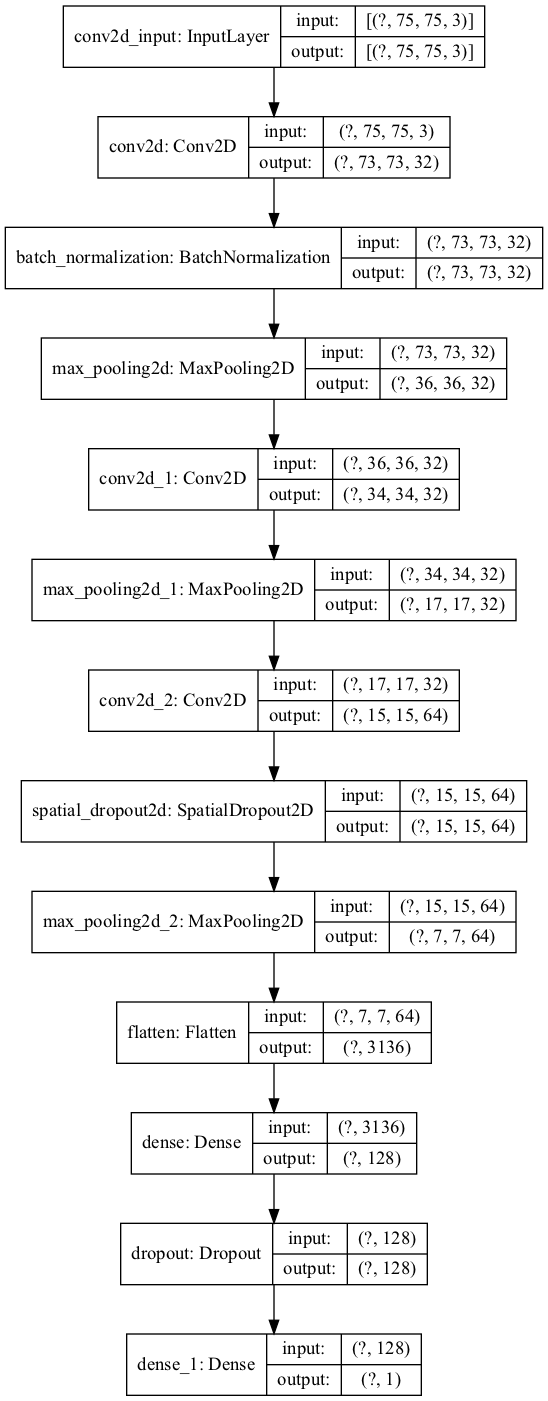

In [37]:
plot_model(CNN, to_file='../models/femaleeyes-maleeyes-convnet-classifier.png', show_layer_names = True , show_shapes = True)

# 7. Model compilation and training

Now that we have specified the model architecture, we will compile the model for training. For this, we need to specify the loss function (what we are trying to minimize), the optimizer (how we want to do to minimize the loss) and the metric (how we will judge the model's performance). Next, we will call .fit to start training the process.

``Compile`` parameters:

     optimizer - descent of the gradient and descent of the stochastic gradient
     loss - Loss function (binary_crossentropy as there is only one exit)
     metrics - Evaluation metrics (obs - more than one can be placed)

``Fit`` parameters:

     train_data - training database
     epochs - number of seasons
     validation_data - test database
     callbacks - Using EarlyStopping
     validation_steps - number of images to validation

In [25]:
# Compile
CNN.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [26]:
# Start of counting time...
start = dt.datetime.now()

# Train
CNN_model = CNN.fit(training_set, epochs = 50, validation_data = validation_set, callbacks = cb)

# End of counting time...
end = dt.datetime.now()
time_CNN = end - start
print ('\nTraining and validation time is: ', time_CNN)

2022-03-12 21:08:01.108810: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 91 of 244
2022-03-12 21:08:11.132600: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 172 of 244
2022-03-12 21:08:18.539043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


Train for 244 steps, validate for 27 steps
Epoch 1/50


2022-03-12 21:08:33.003821: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 114 of 244
2022-03-12 21:08:42.941595: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 203 of 244
2022-03-12 21:08:46.981182: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 74s 303ms/step - loss: 0.6477 - accuracy: 0.6307 - val_loss: 0.6533 - val_accuracy: 0.6528
Epoch 2/50


2022-03-12 21:09:42.941473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 126 of 244


  1/244 [..............................] - ETA: 1:20:08 - loss: 0.5729 - accuracy: 0.7812

2022-03-12 21:09:52.485276: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 68s 278ms/step - loss: 0.5539 - accuracy: 0.7167 - val_loss: 0.5326 - val_accuracy: 0.7454
Epoch 3/50


2022-03-12 21:10:50.730718: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 107 of 244
2022-03-12 21:11:00.704221: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 202 of 244
2022-03-12 21:11:04.906924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 68s 278ms/step - loss: 0.5083 - accuracy: 0.7550 - val_loss: 0.4463 - val_accuracy: 0.8194
Epoch 4/50


2022-03-12 21:11:58.506830: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 109 of 244
2022-03-12 21:12:08.606872: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 210 of 244


  1/244 [..............................] - ETA: 1:37:15 - loss: 0.5182 - accuracy: 0.7812

2022-03-12 21:12:12.312168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 67s 273ms/step - loss: 0.4547 - accuracy: 0.7860 - val_loss: 0.3984 - val_accuracy: 0.8218
Epoch 5/50


2022-03-12 21:13:05.130693: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 113 of 244
2022-03-12 21:13:15.148275: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 228 of 244


  1/244 [..............................] - ETA: 1:27:47 - loss: 0.3519 - accuracy: 0.8125

2022-03-12 21:13:16.576666: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 65s 267ms/step - loss: 0.4298 - accuracy: 0.8052 - val_loss: 0.4741 - val_accuracy: 0.7720
Epoch 6/50


2022-03-12 21:14:10.306399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 83 of 244
2022-03-12 21:14:20.322056: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 161 of 244


  1/244 [..............................] - ETA: 2:02:29 - loss: 0.2920 - accuracy: 0.9062

2022-03-12 21:14:30.259072: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 243 of 244
2022-03-12 21:14:30.275232: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 79s 324ms/step - loss: 0.4036 - accuracy: 0.8159 - val_loss: 0.3330 - val_accuracy: 0.8553
Epoch 7/50


2022-03-12 21:15:29.446480: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 102 of 244
2022-03-12 21:15:39.475168: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 198 of 244


  1/244 [..............................] - ETA: 1:41:54 - loss: 0.3934 - accuracy: 0.7812

2022-03-12 21:15:44.324900: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 80s 329ms/step - loss: 0.3843 - accuracy: 0.8302 - val_loss: 0.4870 - val_accuracy: 0.7905
Epoch 8/50


2022-03-12 21:16:49.607043: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 95 of 244
2022-03-12 21:16:59.598161: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 206 of 244


  1/244 [..............................] - ETA: 1:35:07 - loss: 0.2467 - accuracy: 0.9375

2022-03-12 21:17:02.876977: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 70s 289ms/step - loss: 0.3703 - accuracy: 0.8373 - val_loss: 0.3528 - val_accuracy: 0.8472
Epoch 9/50


2022-03-12 21:18:00.098147: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 102 of 244
2022-03-12 21:18:10.120384: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 206 of 244


  1/244 [..............................] - ETA: 1:36:58 - loss: 0.3430 - accuracy: 0.6667

2022-03-12 21:18:13.932087: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 66s 269ms/step - loss: 0.3444 - accuracy: 0.8488 - val_loss: 0.3112 - val_accuracy: 0.8785
Epoch 10/50


2022-03-12 21:19:05.650152: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 148 of 244


  1/244 [..............................] - ETA: 1:06:10 - loss: 0.2493 - accuracy: 0.8750

2022-03-12 21:19:11.809079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 56s 231ms/step - loss: 0.3414 - accuracy: 0.8537 - val_loss: 0.3550 - val_accuracy: 0.8507
Epoch 11/50


2022-03-12 21:20:02.023304: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 100 of 244
2022-03-12 21:20:12.091773: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 186 of 244


  1/244 [..............................] - ETA: 1:46:22 - loss: 0.2556 - accuracy: 0.8750

2022-03-12 21:20:18.018784: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 69s 283ms/step - loss: 0.3384 - accuracy: 0.8583 - val_loss: 0.3307 - val_accuracy: 0.8808
Epoch 12/50


2022-03-12 21:21:11.012006: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 123 of 244


  1/244 [..............................] - ETA: 1:17:55 - loss: 0.3855 - accuracy: 0.8125

2022-03-12 21:21:20.047788: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 61s 252ms/step - loss: 0.3167 - accuracy: 0.8655 - val_loss: 0.3094 - val_accuracy: 0.8704
Epoch 13/50


2022-03-12 21:22:12.573569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 100 of 244
2022-03-12 21:22:22.527924: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 211 of 244


  1/244 [..............................] - ETA: 1:32:56 - loss: 0.4379 - accuracy: 0.8125

2022-03-12 21:22:25.218927: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 69s 284ms/step - loss: 0.3286 - accuracy: 0.8609 - val_loss: 0.2907 - val_accuracy: 0.8738
Epoch 14/50


2022-03-12 21:23:21.894020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 110 of 244
2022-03-12 21:23:31.854898: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 230 of 244


  1/244 [..............................] - ETA: 1:26:25 - loss: 0.2875 - accuracy: 0.9062

2022-03-12 21:23:32.970240: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 66s 270ms/step - loss: 0.3075 - accuracy: 0.8721 - val_loss: 0.3260 - val_accuracy: 0.8669
Epoch 15/50


2022-03-12 21:24:27.729735: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 93 of 244
2022-03-12 21:24:37.728523: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 199 of 244


  1/244 [..............................] - ETA: 1:37:17 - loss: 0.2295 - accuracy: 0.9062

2022-03-12 21:24:41.555833: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 70s 286ms/step - loss: 0.2980 - accuracy: 0.8723 - val_loss: 0.2838 - val_accuracy: 0.8843
Epoch 16/50


2022-03-12 21:25:37.583396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 105 of 244
2022-03-12 21:25:47.533327: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 223 of 244


  1/244 [..............................] - ETA: 1:28:20 - loss: 0.4613 - accuracy: 0.8438

2022-03-12 21:25:49.168569: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 72s 296ms/step - loss: 0.3114 - accuracy: 0.8659 - val_loss: 0.2782 - val_accuracy: 0.8727
Epoch 17/50


2022-03-12 21:26:49.847732: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 106 of 244
2022-03-12 21:26:59.846950: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 205 of 244


  1/244 [..............................] - ETA: 1:38:03 - loss: 0.2230 - accuracy: 0.9375

2022-03-12 21:27:03.792912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 69s 282ms/step - loss: 0.2944 - accuracy: 0.8784 - val_loss: 0.2585 - val_accuracy: 0.8912
Epoch 18/50


2022-03-12 21:27:58.624572: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 117 of 244
2022-03-12 21:28:08.597618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 213 of 244


  1/244 [..............................] - ETA: 1:35:57 - loss: 0.3408 - accuracy: 0.8438

2022-03-12 21:28:12.053029: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 67s 276ms/step - loss: 0.2983 - accuracy: 0.8780 - val_loss: 0.2609 - val_accuracy: 0.8912
Epoch 19/50


2022-03-12 21:29:05.981395: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 123 of 244


  1/244 [..............................] - ETA: 1:20:35 - loss: 0.2839 - accuracy: 0.8750

2022-03-12 21:29:15.654001: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 60s 246ms/step - loss: 0.2959 - accuracy: 0.8790 - val_loss: 0.3293 - val_accuracy: 0.8646
Epoch 20/50


2022-03-12 21:30:05.982614: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 92 of 244
2022-03-12 21:30:15.967283: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 200 of 244


  1/244 [..............................] - ETA: 1:36:56 - loss: 0.2643 - accuracy: 0.8438

2022-03-12 21:30:19.630363: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 66s 271ms/step - loss: 0.2991 - accuracy: 0.8775 - val_loss: 0.3572 - val_accuracy: 0.8403
Epoch 21/50


2022-03-12 21:31:12.128403: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 122 of 244


  1/244 [..............................] - ETA: 1:19:56 - loss: 0.1801 - accuracy: 0.9688

2022-03-12 21:31:21.657623: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 62s 253ms/step - loss: 0.2925 - accuracy: 0.8790 - val_loss: 0.2790 - val_accuracy: 0.8912
Epoch 22/50


2022-03-12 21:32:13.804413: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 90 of 244
2022-03-12 21:32:23.806273: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 193 of 244


  1/244 [..............................] - ETA: 1:40:01 - loss: 0.2082 - accuracy: 0.8750

2022-03-12 21:32:28.281377: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 73s 299ms/step - loss: 0.2720 - accuracy: 0.8861 - val_loss: 0.2343 - val_accuracy: 0.9028
Epoch 23/50


2022-03-12 21:33:26.746183: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 114 of 244
2022-03-12 21:33:36.719763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 236 of 244
2022-03-12 21:33:37.312292: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 66s 271ms/step - loss: 0.2746 - accuracy: 0.8828 - val_loss: 0.2699 - val_accuracy: 0.8808
Epoch 24/50


2022-03-12 21:34:33.018940: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 91 of 244
2022-03-12 21:34:42.963762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 207 of 244


  1/244 [..............................] - ETA: 1:33:34 - loss: 0.1764 - accuracy: 0.9375

2022-03-12 21:34:45.863704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 65s 268ms/step - loss: 0.2599 - accuracy: 0.8924 - val_loss: 0.2575 - val_accuracy: 0.8773
Epoch 25/50


2022-03-12 21:35:38.273634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 131 of 244


  1/244 [..............................] - ETA: 1:13:39 - loss: 0.4640 - accuracy: 0.8750

2022-03-12 21:35:46.278704: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 65s 268ms/step - loss: 0.2790 - accuracy: 0.8837 - val_loss: 0.2759 - val_accuracy: 0.8866
Epoch 26/50


2022-03-12 21:36:43.784194: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 117 of 244
2022-03-12 21:36:53.817488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 240 of 244


  1/244 [..............................] - ETA: 1:22:57 - loss: 0.2989 - accuracy: 0.9062

2022-03-12 21:36:54.053388: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 63s 260ms/step - loss: 0.2618 - accuracy: 0.8950 - val_loss: 0.3026 - val_accuracy: 0.8831
Epoch 27/50


2022-03-12 21:37:47.152220: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 139 of 244


  1/244 [..............................] - ETA: 1:11:12 - loss: 0.2172 - accuracy: 0.9062

2022-03-12 21:37:54.579179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 66s 271ms/step - loss: 0.2717 - accuracy: 0.8901 - val_loss: 0.2465 - val_accuracy: 0.8993
Epoch 28/50


2022-03-12 21:38:53.392462: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 125 of 244


  1/244 [..............................] - ETA: 1:20:11 - loss: 0.1777 - accuracy: 0.9375

2022-03-12 21:39:02.967694: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 60s 245ms/step - loss: 0.2514 - accuracy: 0.8959 - val_loss: 0.2246 - val_accuracy: 0.9039
Epoch 29/50


2022-03-12 21:39:53.173137: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 126 of 244


  1/244 [..............................] - ETA: 1:19:13 - loss: 0.4522 - accuracy: 0.8750

2022-03-12 21:40:02.524463: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 65s 268ms/step - loss: 0.2635 - accuracy: 0.8923 - val_loss: 0.2656 - val_accuracy: 0.8889
Epoch 30/50


2022-03-12 21:40:58.672795: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 122 of 244
2022-03-12 21:41:08.665930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 241 of 244
2022-03-12 21:41:08.835955: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 59s 242ms/step - loss: 0.2507 - accuracy: 0.8946 - val_loss: 0.2279 - val_accuracy: 0.8970
Epoch 31/50


2022-03-12 21:41:57.872966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 128 of 244


  1/244 [..............................] - ETA: 1:16:42 - loss: 0.1460 - accuracy: 0.9375

2022-03-12 21:42:06.615285: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 64s 263ms/step - loss: 0.2574 - accuracy: 0.8956 - val_loss: 0.2467 - val_accuracy: 0.9039
Epoch 32/50


2022-03-12 21:43:01.927688: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 119 of 244


  1/244 [..............................] - ETA: 1:21:14 - loss: 0.2214 - accuracy: 0.8750

2022-03-12 21:43:11.812060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 60s 245ms/step - loss: 0.2399 - accuracy: 0.9032 - val_loss: 0.1930 - val_accuracy: 0.9190
Epoch 33/50


2022-03-12 21:44:01.686280: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 128 of 244


  1/244 [..............................] - ETA: 1:15:56 - loss: 0.1675 - accuracy: 0.9375

2022-03-12 21:44:10.215713: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 62s 253ms/step - loss: 0.2499 - accuracy: 0.9006 - val_loss: 0.2174 - val_accuracy: 0.9167
Epoch 34/50


2022-03-12 21:45:03.504042: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 101 of 244
2022-03-12 21:45:13.481389: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 227 of 244


  1/244 [..............................] - ETA: 1:27:10 - loss: 0.2959 - accuracy: 0.8750

2022-03-12 21:45:14.812057: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 62s 254ms/step - loss: 0.2436 - accuracy: 0.9027 - val_loss: 0.2440 - val_accuracy: 0.9051
Epoch 35/50


2022-03-12 21:46:05.410247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 128 of 244


  1/244 [..............................] - ETA: 1:15:24 - loss: 0.3973 - accuracy: 0.8438

2022-03-12 21:46:13.819016: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 59s 243ms/step - loss: 0.2504 - accuracy: 0.8973 - val_loss: 0.2331 - val_accuracy: 0.8981
Epoch 36/50


2022-03-12 21:47:04.773797: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 97 of 244
2022-03-12 21:47:14.810489: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 195 of 244


  1/244 [..............................] - ETA: 1:40:34 - loss: 0.1845 - accuracy: 0.9375

2022-03-12 21:47:19.367195: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 66s 270ms/step - loss: 0.2401 - accuracy: 0.9035 - val_loss: 0.2480 - val_accuracy: 0.8935
Epoch 37/50


2022-03-12 21:48:10.704722: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 121 of 244


  1/244 [..............................] - ETA: 1:18:03 - loss: 0.3181 - accuracy: 0.9062

2022-03-12 21:48:19.797859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 62s 255ms/step - loss: 0.2315 - accuracy: 0.9063 - val_loss: 0.3066 - val_accuracy: 0.8715
Epoch 38/50


2022-03-12 21:49:12.988340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 94 of 244
2022-03-12 21:49:22.932391: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 214 of 244


  1/244 [..............................] - ETA: 1:31:45 - loss: 0.2293 - accuracy: 0.9375

2022-03-12 21:49:25.406399: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 63s 258ms/step - loss: 0.2369 - accuracy: 0.9029 - val_loss: 0.2752 - val_accuracy: 0.8900
Epoch 39/50


2022-03-12 21:50:15.962510: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 127 of 244


  1/244 [..............................] - ETA: 1:15:30 - loss: 0.1676 - accuracy: 0.9688

2022-03-12 21:50:24.442027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 59s 240ms/step - loss: 0.2489 - accuracy: 0.8987 - val_loss: 0.2581 - val_accuracy: 0.8889
Epoch 40/50


2022-03-12 21:51:14.575734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 96 of 244
2022-03-12 21:51:24.498155: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 222 of 244


  1/244 [..............................] - ETA: 1:28:41 - loss: 0.2393 - accuracy: 0.9062

2022-03-12 21:51:26.227966: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 61s 250ms/step - loss: 0.2406 - accuracy: 0.8981 - val_loss: 0.2682 - val_accuracy: 0.8958
Epoch 41/50


2022-03-12 21:52:15.618306: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 128 of 244


  1/244 [..............................] - ETA: 1:15:12 - loss: 0.0831 - accuracy: 0.9688

2022-03-12 21:52:23.962392: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 56s 229ms/step - loss: 0.2351 - accuracy: 0.9024 - val_loss: 0.2529 - val_accuracy: 0.8877
Epoch 42/50


2022-03-12 21:53:11.563930: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 127 of 244


  1/244 [..............................] - ETA: 1:21:52 - loss: 0.0884 - accuracy: 0.9688

2022-03-12 21:53:21.511631: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 243 of 244
2022-03-12 21:53:21.524829: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 64s 264ms/step - loss: 0.2309 - accuracy: 0.9046 - val_loss: 0.2157 - val_accuracy: 0.9097
Epoch 43/50


2022-03-12 21:54:15.969473: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 121 of 244


  1/244 [..............................] - ETA: 1:20:21 - loss: 0.1875 - accuracy: 0.9062

2022-03-12 21:54:25.645650: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 59s 240ms/step - loss: 0.2241 - accuracy: 0.9099 - val_loss: 0.2217 - val_accuracy: 0.9016
Epoch 44/50


2022-03-12 21:55:14.590005: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 128 of 244


  1/244 [..............................] - ETA: 1:15:40 - loss: 0.2758 - accuracy: 0.8750

2022-03-12 21:55:23.053646: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 64s 264ms/step - loss: 0.2310 - accuracy: 0.9083 - val_loss: 0.2105 - val_accuracy: 0.9236
Epoch 45/50


2022-03-12 21:56:18.910222: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 137 of 244


  1/244 [..............................] - ETA: 1:12:43 - loss: 0.2416 - accuracy: 0.9062

2022-03-12 21:56:26.658813: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 57s 232ms/step - loss: 0.2371 - accuracy: 0.9042 - val_loss: 0.2523 - val_accuracy: 0.8981
Epoch 46/50


2022-03-12 21:57:15.582098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 156 of 244


  1/244 [..............................] - ETA: 1:04:01 - loss: 0.3134 - accuracy: 0.8750

2022-03-12 21:57:21.206618: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 57s 234ms/step - loss: 0.2314 - accuracy: 0.9035 - val_loss: 0.2361 - val_accuracy: 0.9097
Epoch 47/50


2022-03-12 21:58:12.656856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 105 of 244
2022-03-12 21:58:22.672307: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 223 of 244


  1/244 [..............................] - ETA: 1:28:01 - loss: 0.2452 - accuracy: 0.9375

2022-03-12 21:58:24.162322: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 62s 254ms/step - loss: 0.2465 - accuracy: 0.9019 - val_loss: 0.2189 - val_accuracy: 0.9155
Epoch 48/50


2022-03-12 21:59:14.635738: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 149 of 244


  1/244 [..............................] - ETA: 1:05:50 - loss: 0.2067 - accuracy: 0.9375

2022-03-12 21:59:20.713360: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 55s 225ms/step - loss: 0.2418 - accuracy: 0.9023 - val_loss: 0.2627 - val_accuracy: 0.8924
Epoch 49/50


2022-03-12 22:00:09.609556: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 106 of 244
2022-03-12 22:00:19.604709: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 230 of 244


  1/244 [..............................] - ETA: 1:25:38 - loss: 0.2175 - accuracy: 0.9062

2022-03-12 22:00:20.565109: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 61s 248ms/step - loss: 0.2276 - accuracy: 0.9059 - val_loss: 0.1926 - val_accuracy: 0.9155
Epoch 50/50


2022-03-12 22:01:10.142090: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:143] Filling up shuffle buffer (this may take a while): 156 of 244


  1/244 [..............................] - ETA: 1:03:53 - loss: 0.5054 - accuracy: 0.8125

2022-03-12 22:01:15.740129: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:193] Shuffle buffer filled.


244/244 [==============================] - 53s 217ms/step - loss: 0.2227 - accuracy: 0.9122 - val_loss: 0.1936 - val_accuracy: 0.9144

Training and validation time is:  0:54:02.199767


In [30]:
print ('\nTraining and validation time is: ', time_CNN)


Training and validation time is:  0:54:02.199767


# 8. Model training history

We can see how accuracy improves over time, eventually leveling off. Correspondingly, the loss decreases over time. Plots like these can help diagnose overfitting. If we had seen an upward curve in the loss of validation over time (a U shape in the graph), we would suspect that the model was starting to memorize the test set and would not generalize well to new data.

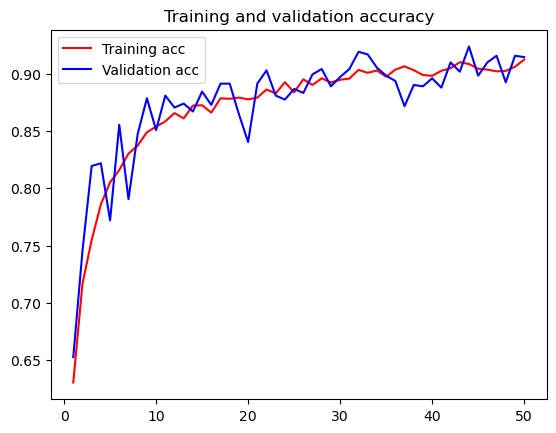

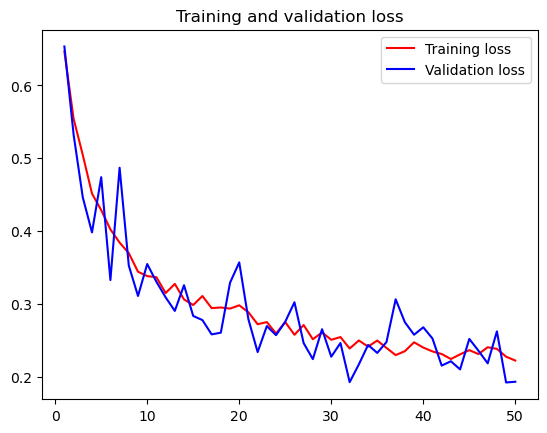

In [187]:
plt.style.use("default")
acc = CNN_model.history['accuracy']
val_acc = CNN_model.history['val_accuracy']
loss = CNN_model.history['loss']
val_loss = CNN_model.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()

## Save model (or reload from previous session)

In [118]:
# Save or reload the model.
# To load, need to downgrade h5py from 3.6
# pip install 'h5py==2.10.0' --force-reinstall
# now Anaconda doesn't list any version of h5py installed, but works anyway...
# https://stackoverflow.com/questions/53740577/does-any-one-got-attributeerror-str-object-has-no-attribute-decode-whi

reload = 1
modelFileName = '../models/femaleeyes-maleeyes-convnet-classifier.h5'
if reload:
    CNN = load_model(modelFileName)
else:
    CNN.save(modelFileName)
    print('model saved as', modelFileName)

# 9. Viewing results and generating forecasts

In [119]:
score_CNN = CNN.evaluate(test_set)
print("Test Loss:", score_CNN[0])
print("Test Accuracy:", score_CNN[1])

91/91 [==============================] - 10s 112ms/step - loss: 0.1602 - accuracy: 0.9323
Test Loss: 0.1601842816223155
Test Accuracy: 0.93233865


In [152]:
start = dt.datetime.now()
y_pred_CNN_raw = CNN.predict(test_set)
y_pred_CNN = np.round(y_pred_CNN_raw)
end = dt.datetime.now()
time_CNN = end - start

print ('Prediction seconds per image is: ', time_CNN.seconds/test_set.samples)

Prediction seconds per image is:  0.002775850104094379


In [121]:
recall_CNN = recall_score(y_test, y_pred_CNN)
precision_CNN = precision_score(y_test, y_pred_CNN)
f1_CNN = f1_score(y_test, y_pred_CNN)
roc_CNN = roc_auc_score(y_test, y_pred_CNN)

In [122]:
print(classification_report(y_test, y_pred_CNN))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      1288
           1       0.92      0.96      0.94      1594

    accuracy                           0.93      2882
   macro avg       0.93      0.93      0.93      2882
weighted avg       0.93      0.93      0.93      2882



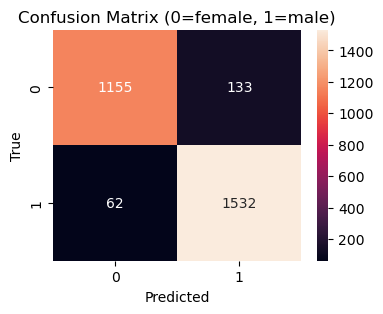

In [137]:
plt.style.use("default")
plt.figure(figsize = (4, 3))

sns.heatmap(confusion_matrix(y_test, y_pred_CNN),annot = True, fmt = 'd')
plt.title("Confusion Matrix (0=female, 1=male)")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# 10. Evaluate misclassifications

To testset_df, add the continuous prediction score, final prediction, and whether correctly predicted.  Characterize the misclassifications. 

In [124]:
#y_pred_CNN_raw is an array of arrays so not a 1d vector.  Need to flatten it before can add to a dataframe.
display(y_pred_CNN_raw)
y_pred_CNN_raw.flatten()

array([[7.2406673e-01],
       [2.8452873e-03],
       [6.5472275e-01],
       ...,
       [1.6850233e-04],
       [1.0000000e+00],
       [9.3538737e-01]], dtype=float32)

array([7.2406673e-01, 2.8452873e-03, 6.5472275e-01, ..., 1.6850233e-04,
       1.0000000e+00, 9.3538737e-01], dtype=float32)

In [125]:
# also convert rounded y_pred_CNN to integer, so easier to compare with expected label.
testset_df2 = pd.concat([
                         testset_df2[['index','File','Label','Label_numeric']],
                         pd.Series(data=y_pred_CNN.flatten().astype(int),name='y_pred_CNN'),
                         pd.Series(data=y_pred_CNN_raw.flatten(),name='y_pred_CNN_raw')
                        ], axis=1)

testset_df2['correct_pred'] = testset_df2['Label_numeric']==testset_df2['y_pred_CNN']
testset_df2.head(10)

,index,File,Label,Label_numeric,y_pred_CNN,y_pred_CNN_raw,correct_pred
0,3814,../input/eyes-rtte/femaleeyes/2278.jpg,femaleeyes,0,1,0.724067,False
1,5238,../input/eyes-rtte/femaleeyes/4920.jpg,femaleeyes,0,0,0.002845,True
2,2768,../input/eyes-rtte/femaleeyes/7195.jpg,femaleeyes,0,1,0.654723,False
3,2398,../input/eyes-rtte/maleeyes/1881.jpg,maleeyes,1,1,0.981550,True
4,9093,../input/eyes-rtte/maleeyes/6197.jpg,maleeyes,1,1,0.996118,True
5,3179,../input/eyes-rtte/femaleeyes/6546.jpg,femaleeyes,0,0,0.000804,True
6,10846,../input/eyes-rtte/maleeyes/4050.jpg,maleeyes,1,1,0.999373,True
7,9405,../input/eyes-rtte/maleeyes/4912.jpg,maleeyes,1,1,0.958173,True
8,1017,../input/eyes-rtte/maleeyes/5968.jpg,maleeyes,1,1,0.603187,True
9,6860,../input/eyes-rtte/femaleeyes/871.jpg,femaleeyes,0,0,0.229737,True


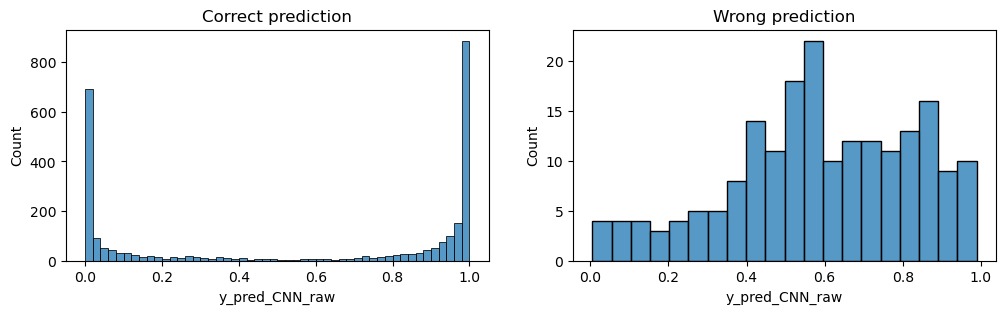

In [126]:
plt.style.use("default")
plt.subplots(figsize=(12,3))
plt.subplot(121)
sns.histplot(data=testset_df2[testset_df2.correct_pred==True], x='y_pred_CNN_raw',
             bins=50).set(title='Correct prediction');
plt.subplot(122)
sns.histplot(data=testset_df2[testset_df2.correct_pred==False],x='y_pred_CNN_raw',
             bins=20).set(title='Wrong prediction');

In [127]:
very_good_male_predictions = testset_df2[(testset_df2.correct_pred==True) & (testset_df2.y_pred_CNN_raw > 0.9999994)]
very_good_male_predictions.shape

(9, 7)

Very high confidence predictions


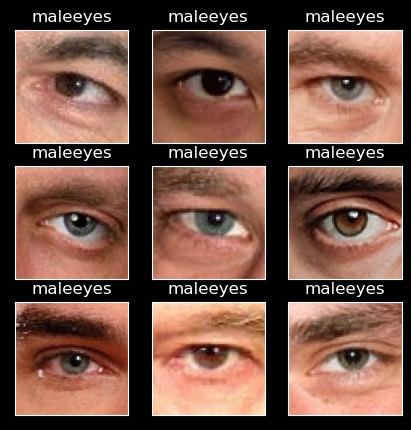

In [128]:
plt.style.use("dark_background")
print('Very high confidence predictions')
fig, axes = plt.subplots(nrows = 3,
                        ncols = 3,
                        figsize = (5, 5),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(very_good_male_predictions["File"].iloc[i]))
    ax.set_title(very_good_male_predictions["Label"].iloc[i])

In [129]:
very_bad_male_predictions = testset_df2[(testset_df2.correct_pred==False) & (testset_df2.y_pred_CNN_raw > 0.94)]
very_bad_male_predictions.shape

(10, 7)

Wrong high confidence MALE predictions


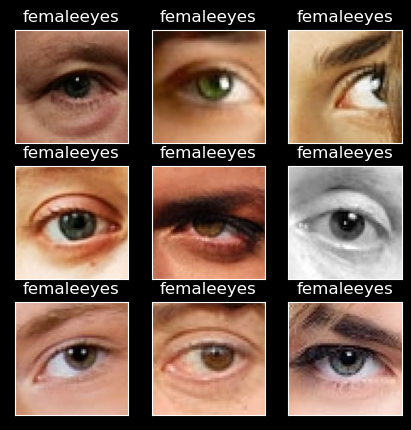

In [130]:
print('Wrong high confidence MALE predictions')
fig, axes = plt.subplots(nrows = 3,
                        ncols = 3,
                        figsize = (5, 5),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(very_bad_male_predictions["File"].iloc[i]))
    ax.set_title(very_bad_male_predictions["Label"].iloc[i])

In [131]:
very_good_female_predictions = testset_df2[(testset_df2.correct_pred==True) & (testset_df2.y_pred_CNN_raw < 0.0000007)]
very_good_female_predictions.shape

(9, 7)

Very high confidence predictions


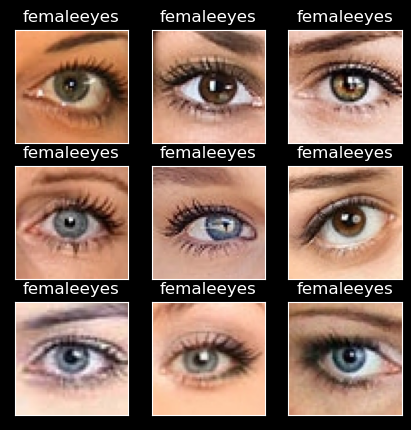

In [132]:
print('Very high confidence predictions')
fig, axes = plt.subplots(nrows = 3,
                        ncols = 3,
                        figsize = (5, 5),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(very_good_female_predictions["File"].iloc[i]))
    ax.set_title(very_good_female_predictions["Label"].iloc[i])

In [133]:
very_bad_female_predictions = testset_df2[(testset_df2.correct_pred==False) & (testset_df2.y_pred_CNN_raw < 0.12)]
very_bad_female_predictions.shape

(9, 7)

Wrong high confidence FEMALE predictions


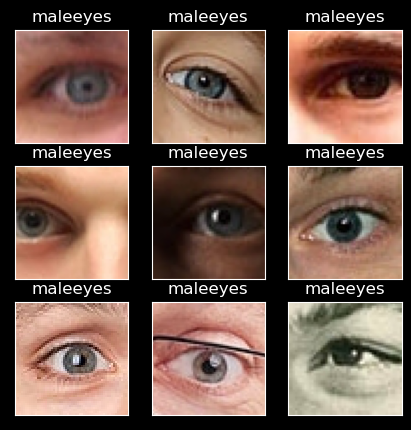

In [134]:
print('Wrong high confidence FEMALE predictions')
fig, axes = plt.subplots(nrows = 3,
                        ncols = 3,
                        figsize = (5, 5),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(very_bad_female_predictions["File"].iloc[i]))
    ax.set_title(very_bad_female_predictions["Label"].iloc[i])

In [135]:
low_confidence_predictions = testset_df2[abs(testset_df2.y_pred_CNN_raw - 0.5) < 0.01]
low_confidence_predictions.shape

(10, 7)

very low confidence predictions


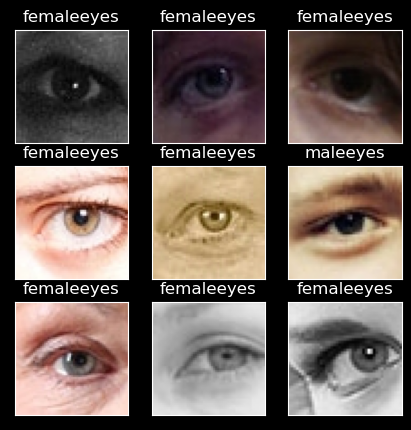

In [136]:
print('very low confidence predictions')
fig, axes = plt.subplots(nrows = 3,
                        ncols = 3,
                        figsize = (5, 5),
                        subplot_kw = {"xticks":[],"yticks":[]})

for i,ax in enumerate(axes.flat):
    ax.imshow(plt.imread(low_confidence_predictions["File"].iloc[i]))
    ax.set_title(low_confidence_predictions["Label"].iloc[i])

# 11. Feature Extraction

https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

I ran out of time to walk one male and female eye image through the CNN and evaluate the intermediate outputs, like plotting a mosaic of the 32 or 64 different filter layer outputs of each MaxPooling layer.